In [4]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score
import os
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap


/var/folders/zg/ds4nwmvx3kq28hn4r4zwbbw80000gp/T/ipykernel_47446/3827359723.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [5]:
ds_version = "V1_0"
root_data_path = os.path.join("..", "data", ds_version) # TODO: prediction folder, see prediction file
data_path = os.path.join(root_data_path, "metadata") # TODO: prediction folder, see prediction file

wandb_train_acc = pd.read_csv(os.path.join(data_path, "wandb_export_efficientnet_a_train_acc.csv"))
wandb_train_loss = pd.read_csv(os.path.join(data_path, "wandb_export_efficientnet_a_train_loss.csv"))
wandb_valid_acc = pd.read_csv(os.path.join(data_path, "wandb_export_efficientnet_a_eval_acc.csv"))
wandb_valid_loss = pd.read_csv(os.path.join(data_path, "wandb_export_efficientnet_a_eval_loss.csv"))

In [14]:
report_df = {}
for seed in [
    "42",
    "1024",
    "3",
    "57",
    "1000",
    ]:
    idx = wandb_valid_loss[f"efficientnet_a_s{seed} - eval/loss"].idxmin()
    report = {
        "train_acc": wandb_train_acc[f"efficientnet_a_s{seed} - train/acc"].loc[idx],
        "train_loss": wandb_train_loss[f"efficientnet_a_s{seed} - train/loss"].loc[idx],
        "valid_acc": wandb_valid_acc[f"efficientnet_a_s{seed} - eval/acc"].loc[idx],
        "valid_loss": wandb_valid_loss[f"efficientnet_a_s{seed} - eval/loss"].loc[idx],
        }
    print(report)
    report = pd.DataFrame(report,index=[seed])
    report_df[seed] = report
report_df = pd.concat(report_df, axis=0)
print(report_df)
mean_df = report_df.mean().round(2)
mean_df


{'train_acc': 0.9729223566133436, 'train_loss': 0.0809598063469409, 'valid_acc': 0.9520958083832336, 'valid_loss': 0.1544285267413019}
{'train_acc': 0.9577058134998048, 'train_loss': 0.1206145999751842, 'valid_acc': 0.9479041916167664, 'valid_loss': 0.1628743798432949}
{'train_acc': 0.9719859539602028, 'train_loss': 0.0823719266698148, 'valid_acc': 0.9389221556886228, 'valid_loss': 0.201826236109266}
{'train_acc': 0.9730003901677722, 'train_loss': 0.0800284746306113, 'valid_acc': 0.9335329341317364, 'valid_loss': 0.1845806627662596}
{'train_acc': 0.9047990635973469, 'train_loss': 0.2643279216767892, 'valid_acc': 0.9179640718562876, 'valid_loss': 0.2262314825714705}
           train_acc  train_loss  valid_acc  valid_loss
42   42     0.972922    0.080960   0.952096    0.154429
1024 1024   0.957706    0.120615   0.947904    0.162874
3    3      0.971986    0.082372   0.938922    0.201826
57   57     0.973000    0.080028   0.933533    0.184581
1000 1000   0.904799    0.264328   0.917964   

train_acc     0.96
train_loss    0.13
valid_acc     0.94
valid_loss    0.19
dtype: float64

In [4]:
ds_version = "V1_0"
annotations_file = "streetSurfaceVis_v1_0.csv"

pred_files = {
    "42": dict(
    pred_file_type = "V1_0_merged_lmh-crop_type_prediction-V1_0_annotated-20240816_065843.csv",
    pred_file_asphalt = "V1_0_merged_lmh-crop_quality_asphalt_prediction-V1_0_annotated_asphalt-20240816_065931.csv",
    pred_file_concrete = "V1_0_merged_lmh-crop_quality_concrete_prediction-V1_0_annotated_concrete-20240816_065947.csv",
    pred_file_paving_stones = "V1_0_merged_lmh-crop_quality_paving_stones_prediction-V1_0_annotated_paving_stones-20240816_070019.csv",
    pred_file_sett = "V1_0_merged_lmh-crop_quality_sett_prediction-V1_0_annotated_sett-20240816_070041.csv",
    pred_file_unpaved = "V1_0_merged_lmh-crop_quality_unpaved_prediction-V1_0_annotated_unpaved-20240816_070058.csv",
    ),
}
root_data_path = os.path.join("..", "data", ds_version) # TODO: prediction folder, see prediction file
data_path = os.path.join(root_data_path, "metadata") # TODO: prediction folder, see prediction file

In [5]:
preds = {}
for seed in [
    "42",
    # "1024",
    # 3,
    # 57,
    # 1000,
    ]:
    files = pred_files[seed]
    pred = pd.DataFrame()
    
    # print(f"reading {pred_file}")
    pred = pd.read_csv(os.path.join(data_path, files["pred_file_type"]))
    pred.rename(columns={"Image": "image_id",  "Level_0": "type_pred"}, inplace=True)

    type_pred = pred[["image_id", "Prediction", "type_pred", "is_in_validation"]]
    type_pred.rename(columns={"Prediction": "class_prob"}, inplace=True)
    idx = type_pred.groupby("image_id")["class_prob"].idxmax()
    type_pred = type_pred.loc[idx]

    asphalt_pred = pd.read_csv(os.path.join(data_path, files["pred_file_asphalt"]))
    concrete_pred = pd.read_csv(os.path.join(data_path, files["pred_file_concrete"]))
    paving_stones_pred = pd.read_csv(os.path.join(data_path, files["pred_file_paving_stones"]))
    sett_pred = pd.read_csv(os.path.join(data_path, files["pred_file_sett"]))
    unpaved_pred = pd.read_csv(os.path.join(data_path, files["pred_file_unpaved"]))

    quality_pred = pd.concat([
        asphalt_pred,
        concrete_pred,
        paving_stones_pred,
        sett_pred,
        unpaved_pred,
    ], ignore_index=True)
    quality_pred.rename(columns={"Image": "image_id",  "Level_0": "quality_pred"}, inplace=True)
    quality_pred = quality_pred[["image_id", "Prediction", "quality_pred", "is_in_validation"]]
    quality_pred.rename(columns={"Prediction": "quality_float_pred"}, inplace=True)

    pred = quality_pred.set_index("image_id").join(type_pred.set_index("image_id"), lsuffix="_quality", rsuffix="_type")
    files["pred"] = pred

/var/folders/zg/ds4nwmvx3kq28hn4r4zwbbw80000gp/T/ipykernel_7852/2512046648.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  type_pred.rename(columns={"Prediction": "class_prob"}, inplace=True)


In [19]:
for seed in [
    "42",
    # "1024",
    # 3,
    # 57,
    # 1000,
    ]:
    files = pred_files[seed]

    annot = pd.read_csv(os.path.join(root_data_path, annotations_file))
    annot.rename(columns={"mapillary_image_id": "image_id", "surface_type": "type_true", "surface_quality": "quality_label_true"}, inplace=True)
    annot["type_true"] = annot["type_true"].replace({'asphalt': 'asphalt-concrete', 'concrete': 'asphalt-concrete', 'paving_stones': 'paving_stones-sett', 'sett': 'paving_stones-sett'})
    annot["quality_float_true"] = annot["quality_label_true"].map({"excellent": 1, "good": 2, "intermediate": 3, "bad": 4, "very_bad": 5})
    files["annot"] = annot

In [20]:
pred_files[seed]["annot"]

,image_id,user_id,user_name,captured_at,longitude,latitude,train,type_true,quality_label_true,quality_float_true
0,1000927687276860,103606985215406,dsmm,1655735677353,13.287805,51.502597,True,asphalt-concrete,intermediate,3
1,1001349260556407,102468835332129,ber319,1659015876793,14.426536,52.217757,True,unpaved,bad,4
2,1001419624308587,100232345559807,carlheinz,1698249177500,13.457938,52.512914,True,asphalt-concrete,good,2
3,1001712924422413,100232345559807,carlheinz,1699107239000,13.386874,52.564970,True,asphalt-concrete,excellent,1
4,1001853784055707,102627028648372,kartonage,1652268883000,13.389880,52.546260,True,asphalt-concrete,excellent,1
...,...,...,...,...,...,...,...,...,...,...
9117,435956961754271,103080845264750,teddy73,1657610360090,9.227063,49.181487,False,asphalt-concrete,good,2
9118,152523294419317,103080845264750,teddy73,1681130193000,9.179631,49.120123,False,asphalt-concrete,excellent,1
9119,303366287999275,100562292188203,changchun1,1612977717350,9.172729,49.106565,False,unpaved,bad,4
9120,563555448482947,100562292188203,changchun1,1654801255232,9.176029,49.098283,False,asphalt-concrete,excellent,1


In [21]:
for seed in [
    "42",
    # "1024",
    # 3,
    # 57,
    # 1000,
    ]:
    files = pred_files[seed]
    df = files["pred"].join(
        files["annot"][["image_id", "type_true", "quality_label_true", "quality_float_true", "train"]].set_index("image_id"), how="left")
    df = df[df.train == True]
    files["df"] = df

In [22]:
df.groupby(["type_true", "quality_label_true"]).size()

type_true           quality_label_true
asphalt-concrete    bad                    296
                    excellent             1101
                    good                  1747
                    intermediate          1016
paving_stones-sett  bad                    596
                    excellent              360
                    good                  1117
                    intermediate          1182
unpaved             bad                    339
                    intermediate           305
                    very_bad               287
dtype: int64

In [27]:
for seed in [
    "42",
    # "1024",
    # 3,
    # 57,
    # 1000,
    ]:
    files = pred_files[seed]
    df_valid_type = files["df"][files["df"].is_in_validation_type == 1]
    df_valid_quality = files["df"][files["df"].is_in_validation_quality == 1]
    files["df_valid_type"] = df_valid_type
    files["df_valid_quality"] = df_valid_quality

In [28]:
df[df.is_in_validation_type == df.is_in_validation_quality].shape

(8346, 10)

In [33]:
print(df_valid_type.shape)
# print(df_train_type.shape)
# print(df_valid_type.shape[0] + df_train_type.shape[0])
print(df_valid_quality.shape)
# print(df_train_quality.shape)
# print(df_valid_quality.shape[0] + df_train_quality.shape[0])


(0, 10)
(1260, 10)
(1260, 10)


In [30]:
df_valid_type

,quality_float_pred,quality_pred,is_in_validation_quality,class_prob,type_pred,is_in_validation_type,type_true,quality_label_true,quality_float_true,train
image_id,,,,,,,,,,
110578584434317,4.294669,bad,1,0.997092,asphalt-concrete,1,asphalt-concrete,bad,4,True
1299005513849605,3.899817,bad,1,0.998658,asphalt-concrete,1,asphalt-concrete,bad,4,True
1391166841241877,2.292649,good,1,0.960120,asphalt-concrete,1,asphalt-concrete,bad,4,True
1391242591245225,3.593801,bad,1,0.999954,asphalt-concrete,1,asphalt-concrete,bad,4,True
1641150989429094,2.557100,intermediate,1,0.998858,asphalt-concrete,1,asphalt-concrete,bad,4,True
...,...,...,...,...,...,...,...,...,...,...
862632181002887,4.275739,bad,1,0.999968,unpaved,1,unpaved,very_bad,5,True
908359293726638,4.311470,bad,1,0.999864,unpaved,1,unpaved,very_bad,5,True
923138374903257,4.991987,very_bad,1,0.999640,unpaved,1,unpaved,very_bad,5,True


# Statistics

In [36]:
from sklearn.metrics import classification_report
for seed in [
    "42",
    # "1024",
    # 3,
    # 57,
    # 1000,
    ]:
    files = pred_files[seed]
    df_valid_type = files["df_valid_type"]
    report = classification_report(df_valid_type['type_true'], df_valid_type['type_pred'])
    print(report)

                    precision    recall  f1-score   support

  asphalt-concrete       0.98      0.98      0.98       629
paving_stones-sett       0.99      0.99      0.99       491
           unpaved       0.93      0.96      0.95       140

          accuracy                           0.98      1260
         macro avg       0.97      0.98      0.97      1260
      weighted avg       0.98      0.98      0.98      1260



## Global measures

In [17]:
def compute_measures_cat(true, pred):
    return{
        "accuracy": sum(true == pred) / len(true)
    }

def compute_measures_float(true_float, pred_float):
    m = {
    "accuracy": sum(true_float.round() == pred_float.round()) / len(true_float),
    "correlation": np.corrcoef(true_float, pred_float)[0, 1],
    "r_square": r2_score(true_float, pred_float),
    "mse": mean_squared_error(true_float, pred_float),
    "mae": mean_absolute_error(true_float, pred_float)
    }
    m["rmse"] = np.sqrt(m["mse"])
    return m

#### global measures for type

In [34]:
# all
gm = compute_measures_cat(df.type_true, df.type_pred)
gm_valid = compute_measures_cat(df_valid_type.type_true, df_valid_type.type_pred)
# gm_train = compute_measures_cat(df_train_type.type_true, df_train_type.type_pred)
pd.concat([
    pd.Series(gm, name="all"),
    pd.Series(gm_valid, name="validation"),
    # pd.Series(gm_train, name="train")
    ], axis=1).round(2)

,all,validation
accuracy,0.99,0.98


#### global measures for quality

In [16]:
# all
gm = compute_measures_float(df.quality_float_true, df.quality_float_pred)
gm_valid = compute_measures_float(df_valid_quality.quality_float_true, df_valid_quality.quality_float_pred)
gm_train = compute_measures_float(df_train_quality.quality_float_true, df_train_quality.quality_float_pred)
pd.concat([pd.Series(gm, name="all"), pd.Series(gm_valid, name="validation"), pd.Series(gm_train, name="train")], axis=1).round(3)

,all,validation,train
accuracy,0.861,0.639,0.912
correlation,0.945,0.860,0.965
r_square,0.883,0.732,0.919
mse,0.129,0.301,0.089
mae,0.267,0.434,0.228
rmse,0.359,0.549,0.298


In [21]:
# all
gm = compute_measures_float(df_test.quality_float_true, df_test.quality_float_pred)
pd.concat([pd.Series(gm, name="all test")], axis=1).round(3)

,all test
accuracy,0.611
correlation,0.801
r_square,0.635
mse,0.344
mae,0.461
rmse,0.586


## Surface type

In [16]:
#plt.rcParams.update({'font.size': 14})

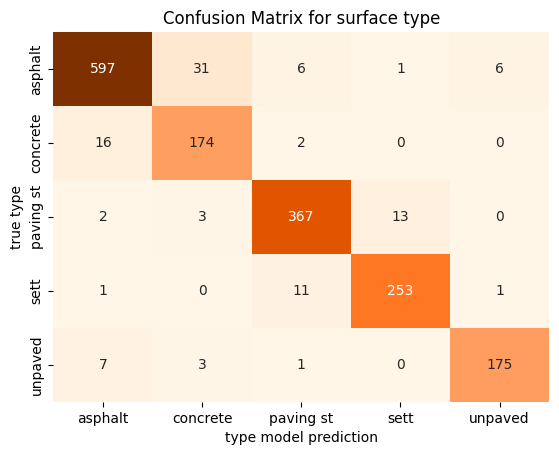

In [17]:
# only validation
# Plotting the confusion matrix using seaborn heatmap
cmap = LinearSegmentedColormap.from_list("mycmap", ["#FFF6E8", "#FF5F00", "#7F3000"])

cm = confusion_matrix(df_valid_type.type_true, df_valid_type.type_pred, labels=["asphalt", "concrete", "paving_stones", "sett", "unpaved"])
plt.figure()
sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, cbar=False,
            xticklabels=["asphalt", "concrete", "paving st", "sett", "unpaved"],
            yticklabels=["asphalt", "concrete", "paving st", "sett", "unpaved"])
plt.title(f"Confusion Matrix for surface type")
plt.xlabel("type model prediction")
plt.ylabel("true type")
plt.savefig("confusion_matrix_type_v1_0.png", transparent=True, bbox_inches='tight')
plt.show()

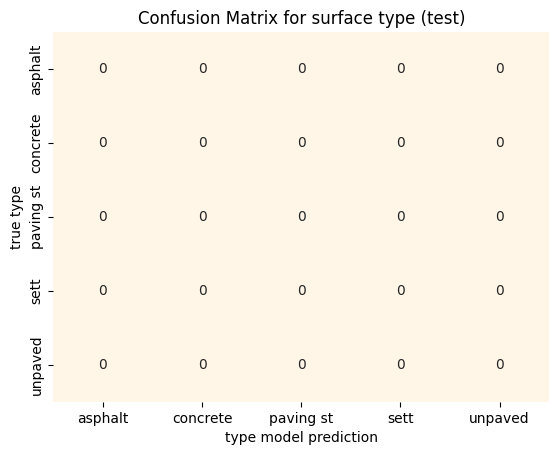

In [18]:
# only validation
# Plotting the confusion matrix using seaborn heatmap
cmap = LinearSegmentedColormap.from_list("mycmap", ["#FFF6E8", "#FF5F00", "#7F3000"])

cm = confusion_matrix(df_test.type_true, df_test.type_pred, labels=["asphalt", "concrete", "paving_stones", "sett", "unpaved"])
plt.figure()
sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, cbar=False,
            xticklabels=["asphalt", "concrete", "paving st", "sett", "unpaved"],
            yticklabels=["asphalt", "concrete", "paving st", "sett", "unpaved"])
plt.title(f"Confusion Matrix for surface type (test)")
plt.xlabel("type model prediction")
plt.ylabel("true type")
plt.savefig("confusion_matrix_type_v1_0_test.png", transparent=True, bbox_inches='tight')
plt.show()

## Measures for quality by surface type

In [19]:
gm_surface = pd.DataFrame()
for surface in df_valid_quality.type_true.unique():
    df_ = df_valid_quality[df_valid_quality.type_true == surface]
    gm = compute_measures_float(df_.quality_float_true, df_.quality_float_pred)
    gm_surface = pd.concat([gm_surface, pd.Series(gm, name=surface)], axis=1)

gm_surface.round(2)

,asphalt,concrete,paving_stones,sett,unpaved
accuracy,0.63,0.74,0.60,0.66,0.62
correlation,0.79,0.83,0.64,0.61,0.75
r_square,0.61,0.68,0.39,0.24,0.54
mse,0.29,0.26,0.35,0.28,0.29
mae,0.43,0.39,0.47,0.42,0.43
rmse,0.54,0.51,0.59,0.53,0.54


## compare float values

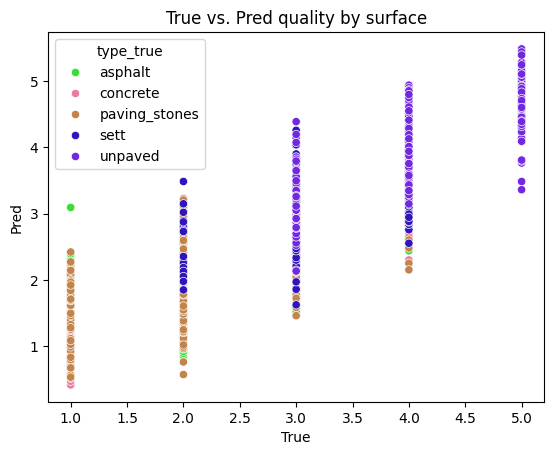

In [20]:
# Plot
np.random.seed(5)
colors = {surface_type: np.random.rand(3,) for surface_type in df_valid_quality.type_true.unique()}

sns.scatterplot(data=df_valid_quality, x="quality_float_true", y="quality_float_pred", hue="type_true", palette=colors, legend="full")
plt.xlabel('True')
plt.ylabel('Pred')
plt.title('True vs. Pred quality by surface')
plt.show()


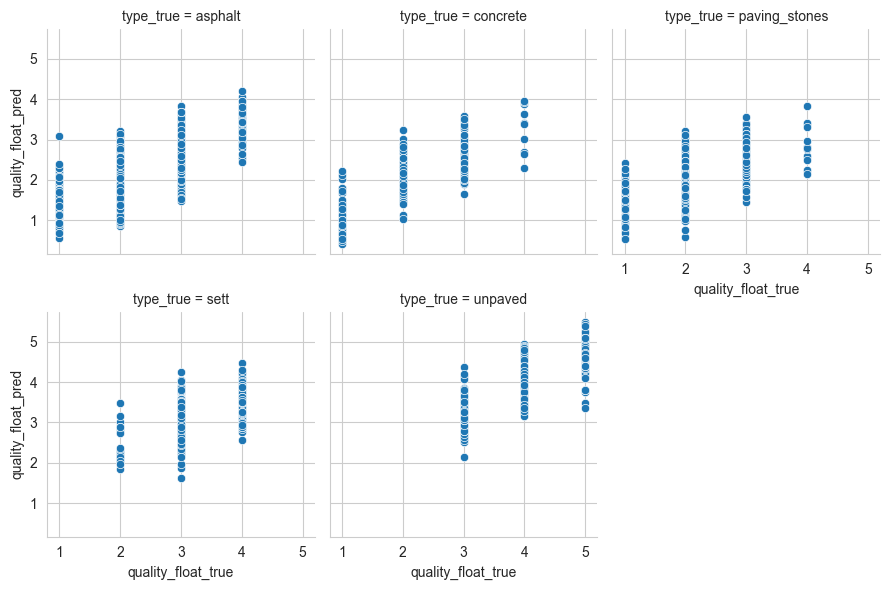

In [21]:
sns.set_style("whitegrid")

# Create a FacetGrid
g = sns.FacetGrid(df_valid_quality, col="type_true", col_wrap=3)

# Map scatter plot for each surface type
g.map(sns.scatterplot, "quality_float_true", "quality_float_pred")

plt.show()

#### Hom much do the deviate?

In [22]:
df_valid_quality.loc[:,"deviation"] = df_valid_quality.quality_float_true - df_valid_quality.quality_float_pred

/var/folders/zg/ds4nwmvx3kq28hn4r4zwbbw80000gp/T/ipykernel_9973/1573003093.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid_quality.loc[:,"deviation"] = df_valid_quality.quality_float_true - df_valid_quality.quality_float_pred


**Overall**

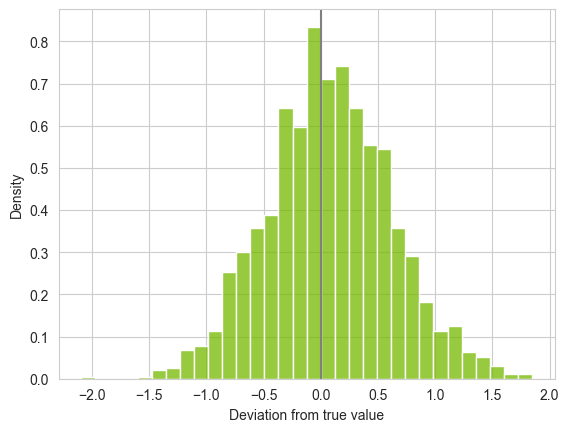

In [23]:
sns.histplot(df_valid_quality, color='#76B900', stat="density", x="deviation")
plt.xlabel("Deviation from true value")
plt.axvline(x=0, color="grey")
plt.savefig("deviation_hist_quality_V1_0.png", transparent=True)
plt.show()


In [24]:
np.mean(df_valid_quality.deviation)

0.07147572947949132

In [25]:
np.std(df_valid_quality.deviation)


0.5441534981138519

In [26]:
(abs(df_valid_quality.deviation) >= 1).value_counts()

deviation
False    1452
True      114
Name: count, dtype: int64

In [27]:
120/len(df_valid_quality)

0.07662835249042145

**by surface**

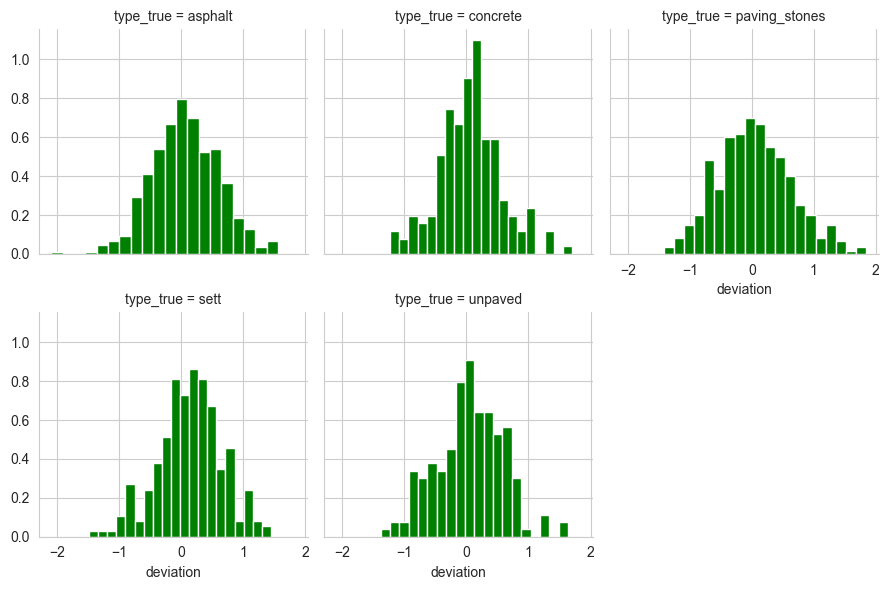

In [28]:
# Create a FacetGrid for histograms
g_hist = sns.FacetGrid(df_valid_quality, col="type_true", col_wrap=3)

# Map histogram for deviation for each surface type
g_hist.map(plt.hist, "deviation", color='green', density=True, bins=20)

plt.show()

## compare classes

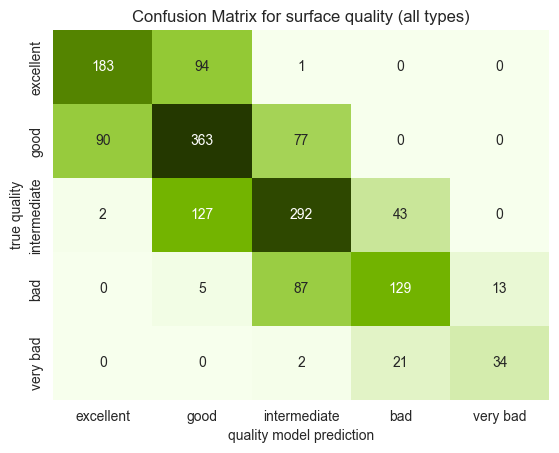

In [29]:
# only validation
# Plotting the confusion matrix using seaborn heatmap
cmap = LinearSegmentedColormap.from_list("mycmap", ["#F7FFED", "#76B900", "#355300", "#243800"])

cm = confusion_matrix(df_valid_quality.quality_label_true, df_valid_quality.quality_label_pred, labels=["excellent", "good", "intermediate", "bad", "very_bad"])
plt.figure()
sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, cbar=False,
            xticklabels=["excellent", "good", "intermediate", "bad", "very bad"],
            yticklabels=["excellent", "good", "intermediate", "bad", "very bad"])
plt.title(f"Confusion Matrix for surface quality (all types)")
plt.xlabel("quality model prediction")
plt.ylabel("true quality")
plt.savefig("confusion_matrix_quality_v1_0.png", transparent=True, bbox_inches='tight')
plt.show()

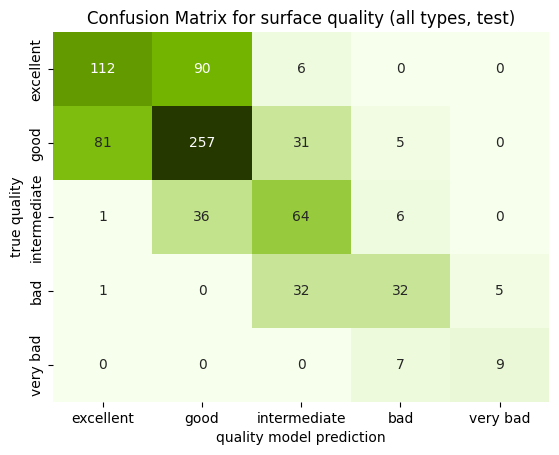

In [23]:
# only validation
# Plotting the confusion matrix using seaborn heatmap
cmap = LinearSegmentedColormap.from_list("mycmap", ["#F7FFED", "#76B900", "#355300", "#243800"])

cm = confusion_matrix(df_test.quality_label_true, df_test.quality_label_pred, labels=["excellent", "good", "intermediate", "bad", "very_bad"])
plt.figure()
sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, cbar=False,
            xticklabels=["excellent", "good", "intermediate", "bad", "very bad"],
            yticklabels=["excellent", "good", "intermediate", "bad", "very bad"])
plt.title(f"Confusion Matrix for surface quality (all types, test)")
plt.xlabel("quality model prediction")
plt.ylabel("true quality")
plt.savefig("confusion_matrix_quality_v1_0_test.png", transparent=True, bbox_inches='tight')
plt.show()

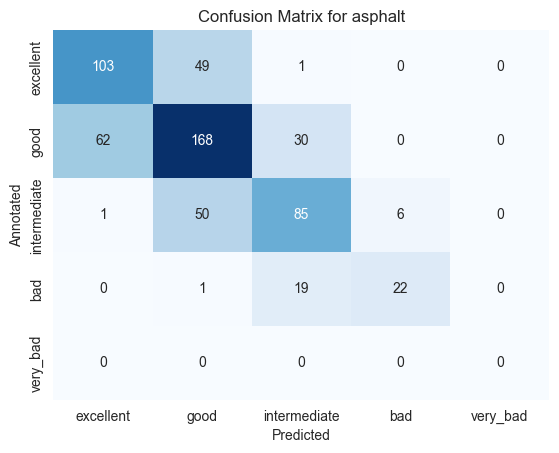

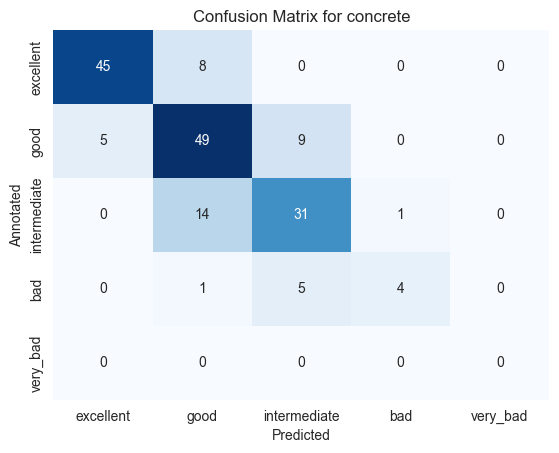

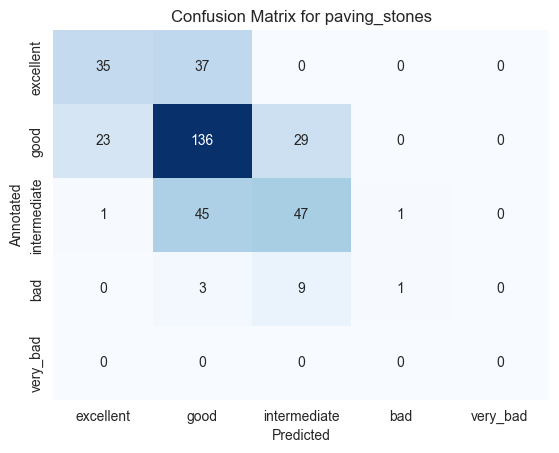

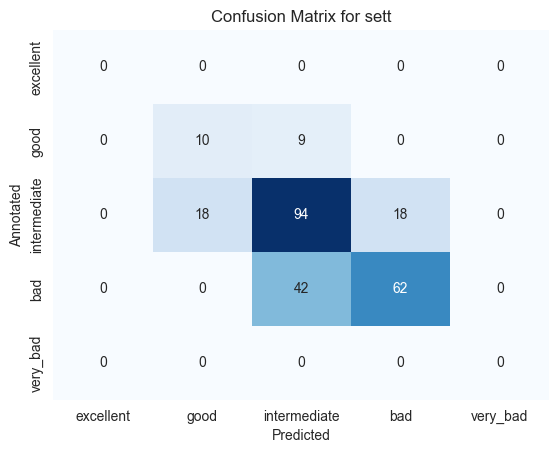

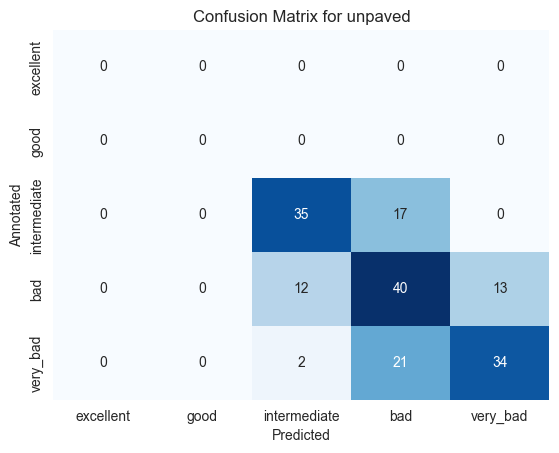

In [30]:
# only validation
# Plotting the confusion matrix using seaborn heatmap
for surface in df_valid_quality.type_true.unique():
    _df = df_valid_quality[(df_valid_quality.type_true == surface)]
    cm = confusion_matrix(_df.quality_label_true, _df.quality_label_pred, labels=["excellent", "good", "intermediate", "bad", "very_bad"])
    plt.figure()
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["excellent", "good", "intermediate", "bad", "very_bad"],
                yticklabels=["excellent", "good", "intermediate", "bad", "very_bad"])
    plt.title(f"Confusion Matrix for {surface}")
    plt.xlabel("Predicted")
    plt.ylabel("Annotated")
    plt.show()



In [32]:
# Extract predicted and ground truth values
precisions = []
recalls = []
f1scores = []
for class_name in df_valid_type['type_true'].unique():
    _df1 = df_valid_type[df_valid_type['type_pred'] == class_name]
    _df2 = df_valid_type[df_valid_type['type_true'] == class_name]
    class_precision = sum(_df1.type_true == class_name) / len(_df1)
    class_recall = sum(_df2.type_pred == class_name) / len(_df2)
    f1score = 2 * (class_precision * class_recall) / (class_precision + class_recall)
    precisions.append(class_precision)
    recalls.append(class_recall)
    f1scores.append(f1score)

    print(f"Class: {class_name}")
    print(f"Count (pred): {len(_df1)}")
    print(f"Count (true): {len(_df2)}")
    print(f"Precision: {round(class_precision, 2)}")
    print(f"Recall: {round(class_recall, 2)}")
    print("------------------------")

print("------------------------")
print("------------------------")

print(f"Average precision: {round(np.mean(precisions), 2)}")
print(f"Average recall: {round(np.mean(recalls), 2)}")
print(f"Average F1-Score: {round(np.mean(f1scores), 2)}")
print(f"Accuracy: {round(sum(df_valid_type.type_true == df_valid_type.type_pred) / len(df_valid_type), 2)}")

Class: asphalt
Count (pred): 623
Count (true): 641
Precision: 0.96
Recall: 0.93
------------------------
Class: concrete
Count (pred): 211
Count (true): 192
Precision: 0.82
Recall: 0.91
------------------------
Class: paving_stones
Count (pred): 387
Count (true): 385
Precision: 0.95
Recall: 0.95
------------------------
Class: sett
Count (pred): 267
Count (true): 266
Precision: 0.95
Recall: 0.95
------------------------
Class: unpaved
Count (pred): 182
Count (true): 186
Precision: 0.96
Recall: 0.94
------------------------
------------------------
------------------------
Average precision: 0.93
Average recall: 0.94
Average F1-Score: 0.93
Accuracy: 0.94
